In [1]:
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Time series analysis

In [2]:
import seaborn as sns
dfatc_daily = pd.read_csv("C:/Users/SUJASH/OneDrive/Desktop/Time Series/data/salesdaily.csv")

In [3]:
dfatc_daily.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


In [4]:
dfatc_daily.shape

(2106, 13)

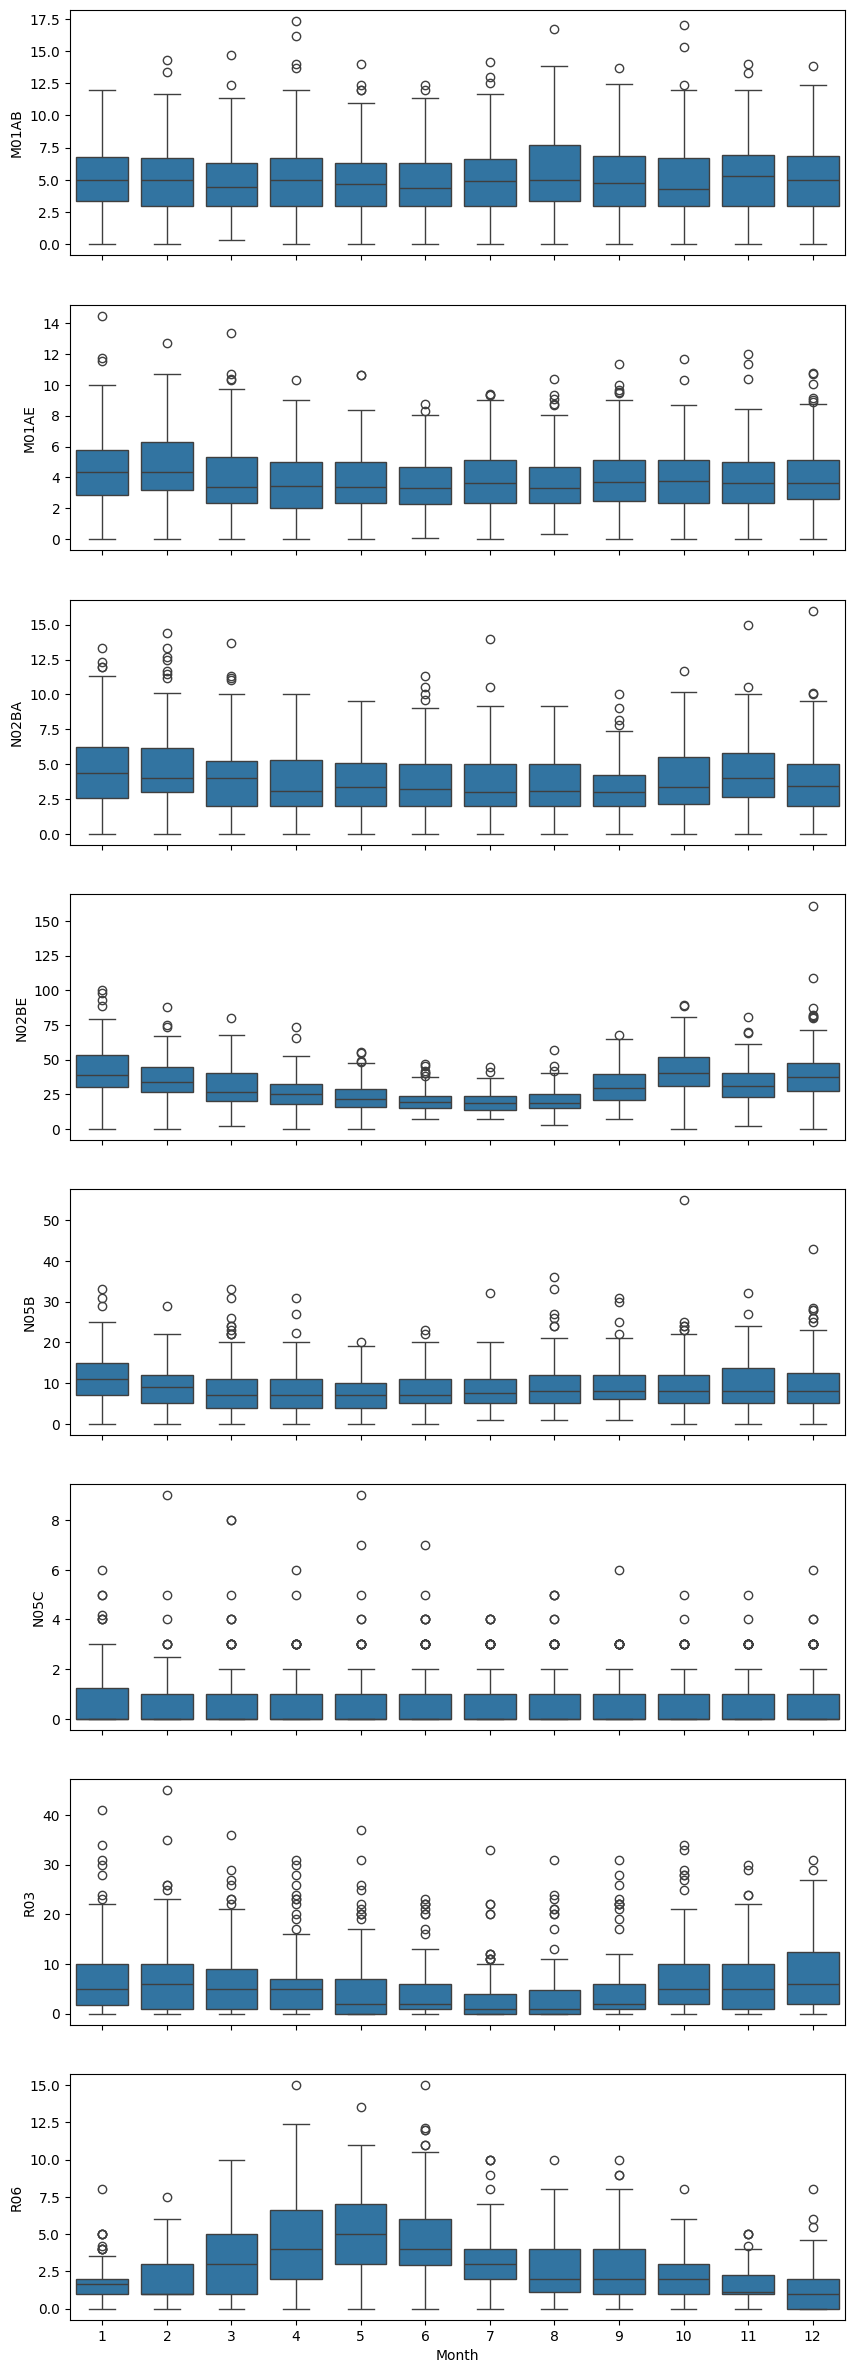

In [5]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Month', y=name, ax=ax)

# The seasonality patterns can be explored in detail by using boxplots.
#Seasonality is clearly confirmed for the categories of R03, R06 and N02BE. Some additional conclusions: R03 and N05C has more outliers that the others, indicating that their sales is more difficult to predict.

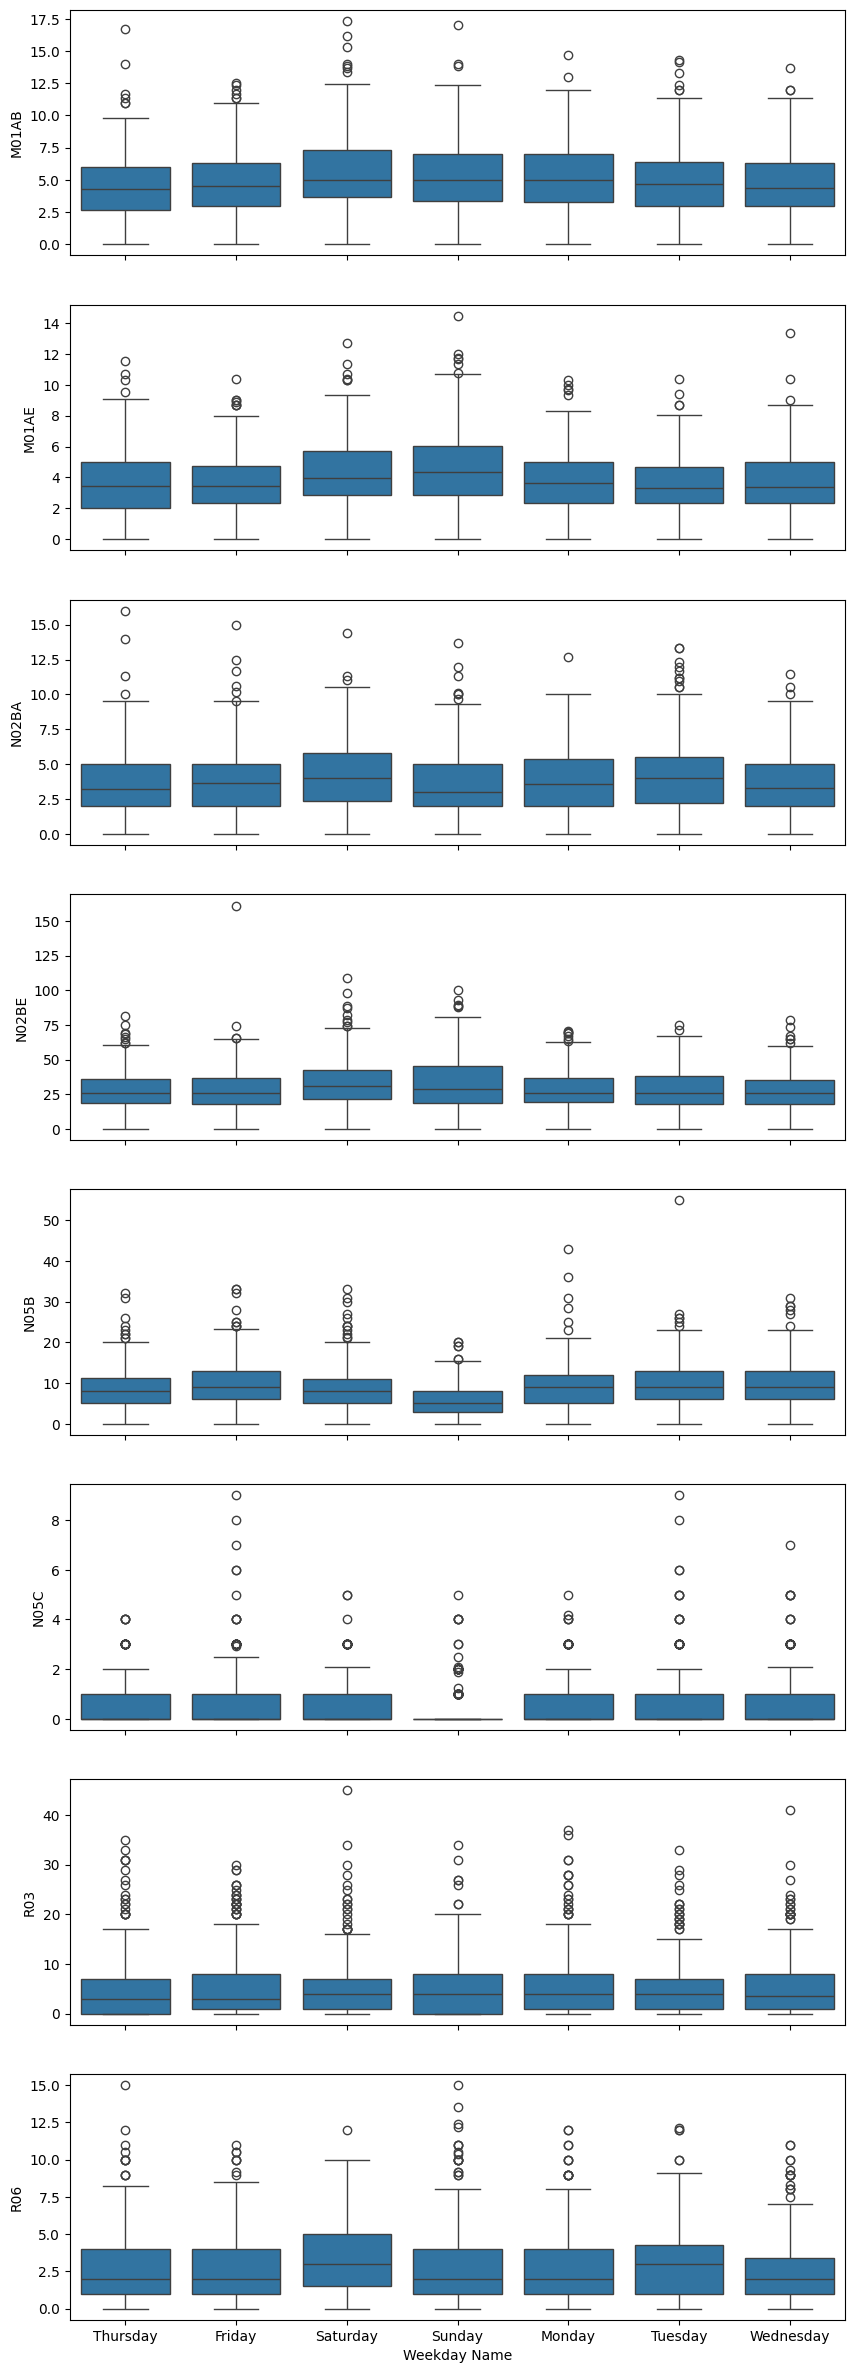

In [6]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Weekday Name', y=name, ax=ax)

#Below, boxplots on a weekly scale are shown, for the purpose of exploring the weakly seasonality. Some weekly seasonality is visible.3

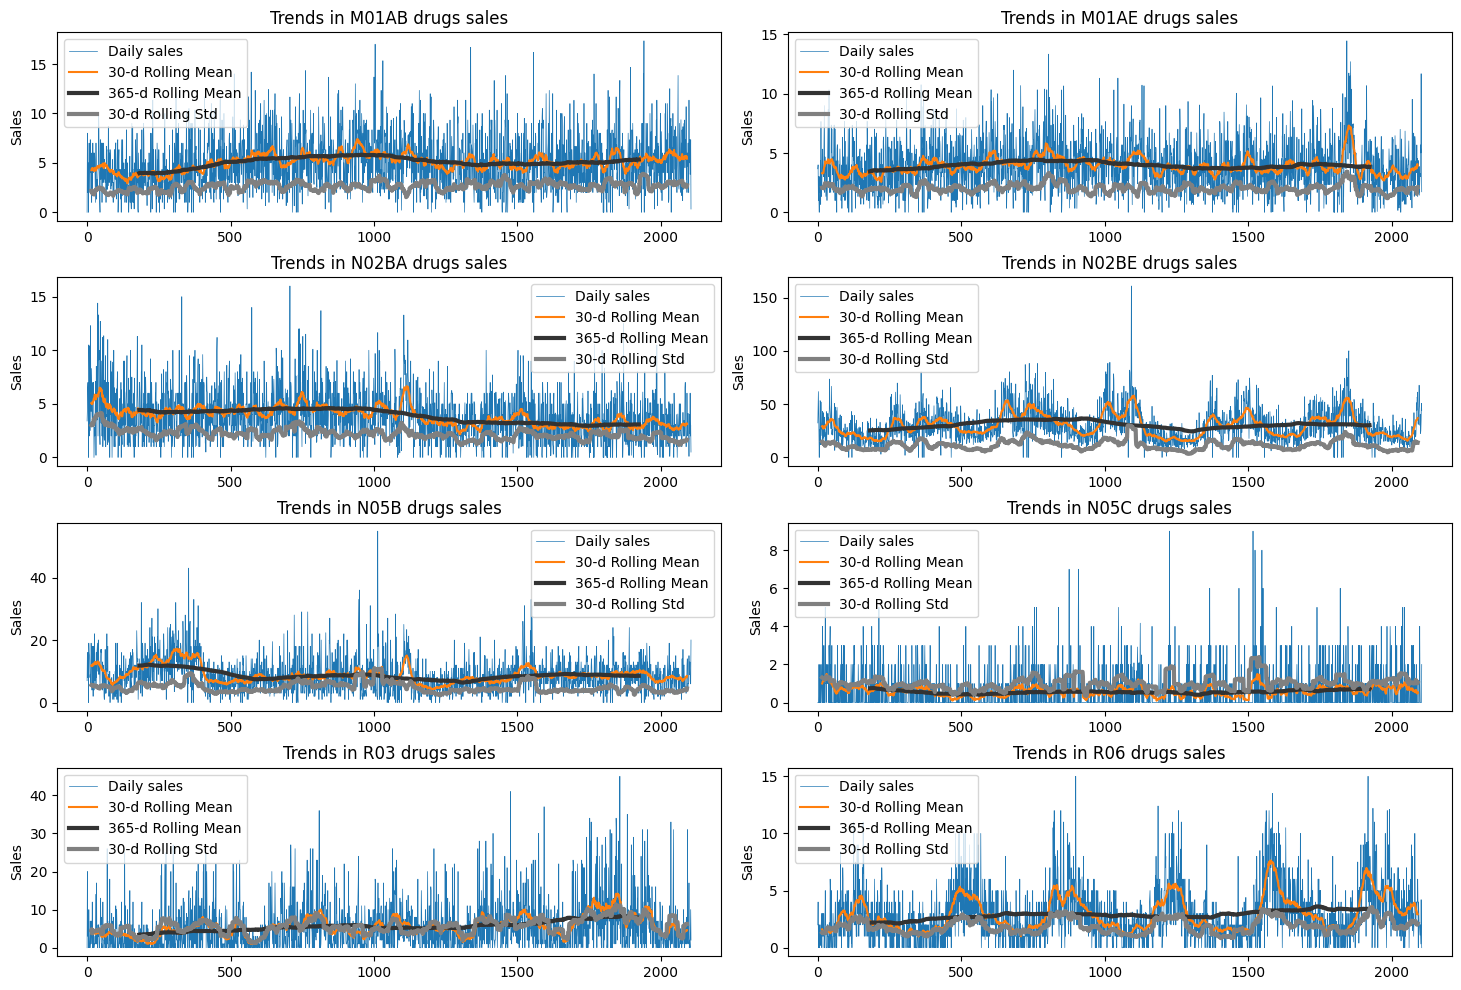

In [7]:
cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='Daily sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');   
    subplotindex=subplotindex+1
plt.show()

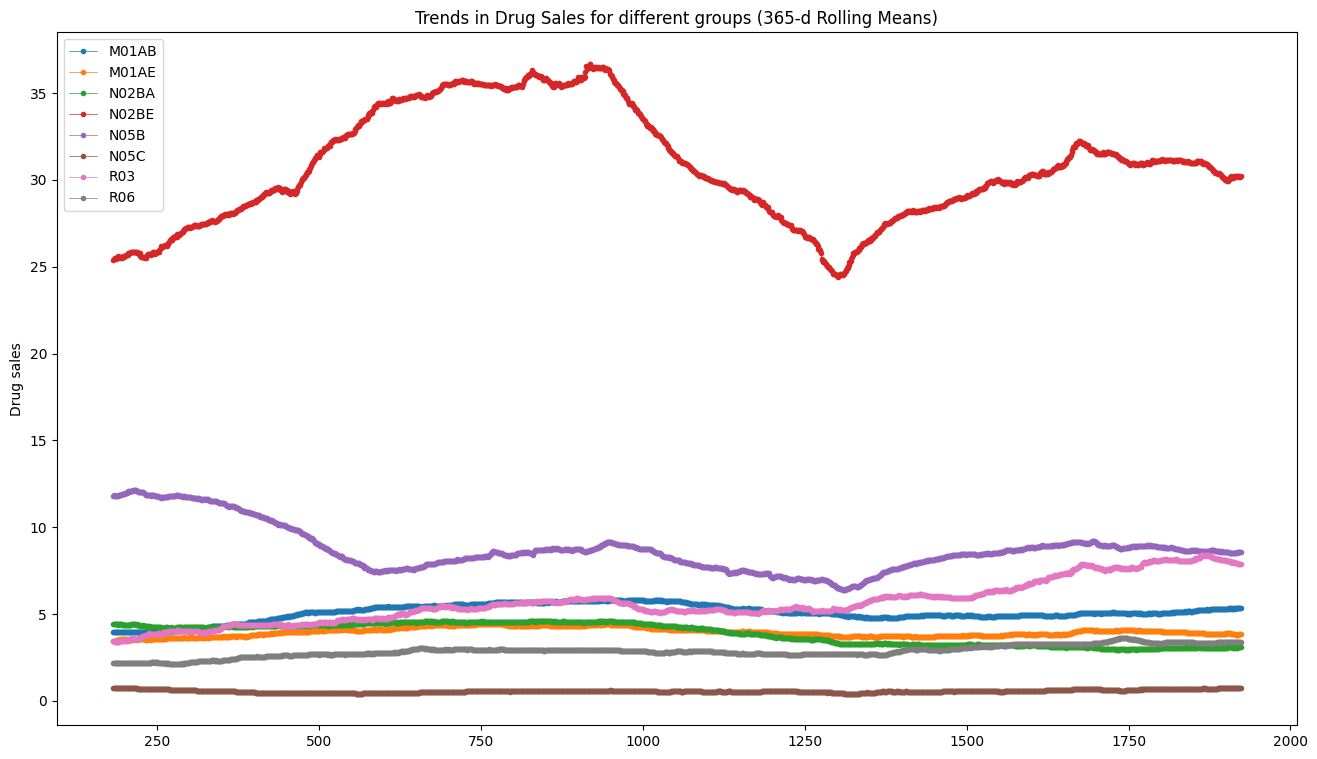

In [8]:
fig, ax = plt.subplots(figsize=(16,9))
for nm in cols_plot:
    ax.plot(dfatc_365d[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Drug sales')
    ax.set_title('Trends in Drug Sales for different groups (365-d Rolling Means)');

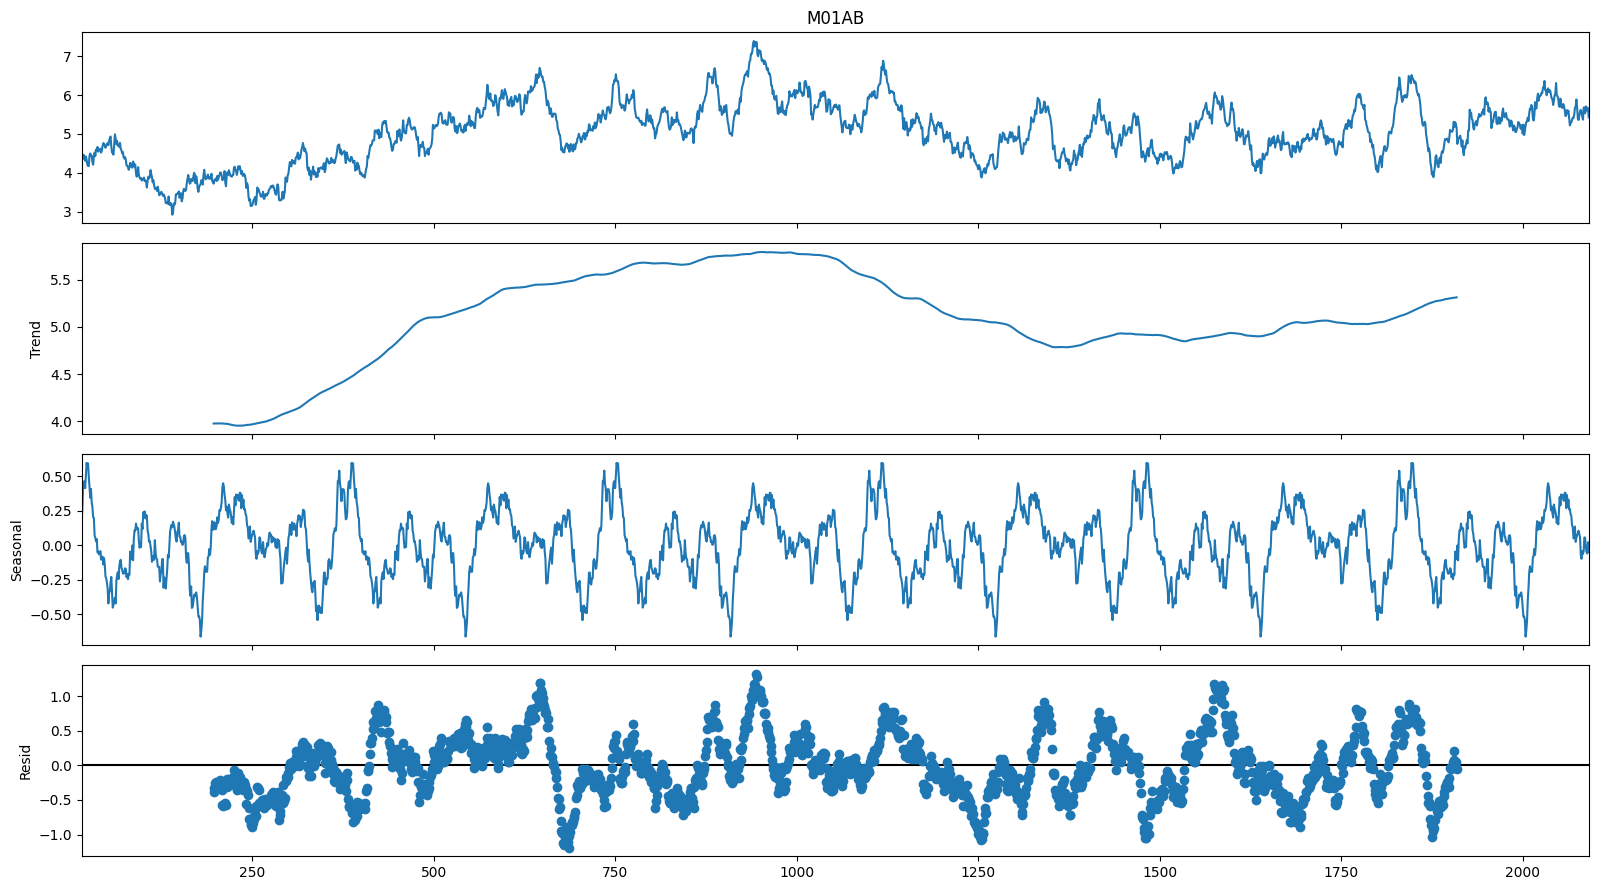

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Applying a rolling mean and dropping NA values
smoothed_data = dfatc_daily['M01AB'].rolling(30, center=True).mean().dropna()

# Decomposing the time series
result = seasonal_decompose(smoothed_data, period=365, model='additive')

# Setting the figure size
plt.rcParams["figure.figsize"] = (16, 9)

# Plotting the decomposition
result.plot()
plt.show()


In [10]:
df = pd.read_csv("C:/Users/SUJASH/OneDrive/Desktop/Time Series/data/salesweekly.csv")
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    result = seasonal_decompose(df[x], period=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

M01AB RESMEAN:5.26715996284115, OBSMEAN:35.59490833332001, PERC:14.797509558159527%
M01AE RESMEAN:4.319542609675869, OBSMEAN:28.00801458336, PERC:15.422523423856601%
N02BA RESMEAN:3.9228389592521657, OBSMEAN:27.083016, PERC:14.484498178682042%
N02BE RESMEAN:29.534357236963668, OBSMEAN:217.6597028336, PERC:13.569051529737028%
N05B RESMEAN:12.94840305932125, OBSMEAN:61.96614999972, PERC:20.895929566997072%
N05C RESMEAN:2.0384606385595405, OBSMEAN:3.871833333332, PERC:52.648460382081936%
R03 RESMEAN:11.722244335544508, OBSMEAN:40.06845833336, PERC:29.25554119906046%
R06 RESMEAN:4.278758416393868, OBSMEAN:19.744589999960002, PERC:21.67053565762842%


# Stationarity analysis

In [11]:
from statsmodels.tsa.stattools import adfuller
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    dftest = adfuller(df[x], regression='ct', autolag='AIC')
    print("ADF test for "+x)
    print("-----------------------------")
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

ADF test for M01AB
-----------------------------
Test statistic = -3.700
P-value = 0.022
Critical values :
	1%: -3.9897903649837616 - The data is not stationary with 99% confidence
	5%: -3.425478311521626 - The data is  stationary with 95% confidence
	10%: -3.1358607194990724 - The data is  stationary with 90% confidence
ADF test for M01AE
-----------------------------
Test statistic = -8.717
P-value = 0.000
Critical values :
	1%: -3.98926783537037 - The data is  stationary with 99% confidence
	5%: -3.425226747185185 - The data is  stationary with 95% confidence
	10%: -3.1357131066666666 - The data is  stationary with 90% confidence
ADF test for N02BA
-----------------------------
Test statistic = -2.670
P-value = 0.249
Critical values :
	1%: -3.990441532957606 - The data is not stationary with 99% confidence
	5%: -3.425791763669738 - The data is not stationary with 95% confidence
	10%: -3.1360446341572343 - The data is not stationary with 90% confidence
ADF test for N02BE
------------

In [12]:
#Augmented Dickey-Fuller (ADF) test have shown that all data, but N02BA (P-value=0.249) in the series were stationary, with maximum confidence.

In [13]:
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    print(" > Is "+x+" data stationary ?")
    dftest = kpss(np.log(df[x]), 'ct')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[3].items():
        print("\t{}: {}".format(k, v))

 > Is M01AB data stationary ?
Test statistic = 0.469
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is M01AE data stationary ?
Test statistic = 0.347
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BA data stationary ?
Test statistic = 0.233
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BE data stationary ?
Test statistic = 0.095
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05B data stationary ?
Test statistic = 0.197
P-value = 0.017
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05C data stationary ?


ValueError: cannot convert float NaN to integer

In [ ]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test found the trend non-stationarity in N02BE, R03 and R06.

# Regularity analysis

In [ ]:
#For calculating regularity and predictability of time series, Approximate Entropy test was used. For all series, entropy values were higher than 1 indicating low predictability, with highest values for M01AE, M01AB and N02BA.

In [14]:
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

M01AB: 1.141130089570642
M01AE: 1.166363924596575
N02BA: 1.1370638730125302
N02BE: 1.058024809082593
N05B: 1.074437415034502
N05C: 1.0361887401424648
R03: 1.1847216239035152
R06: 1.031759595747876


# Autocorrelation analysis

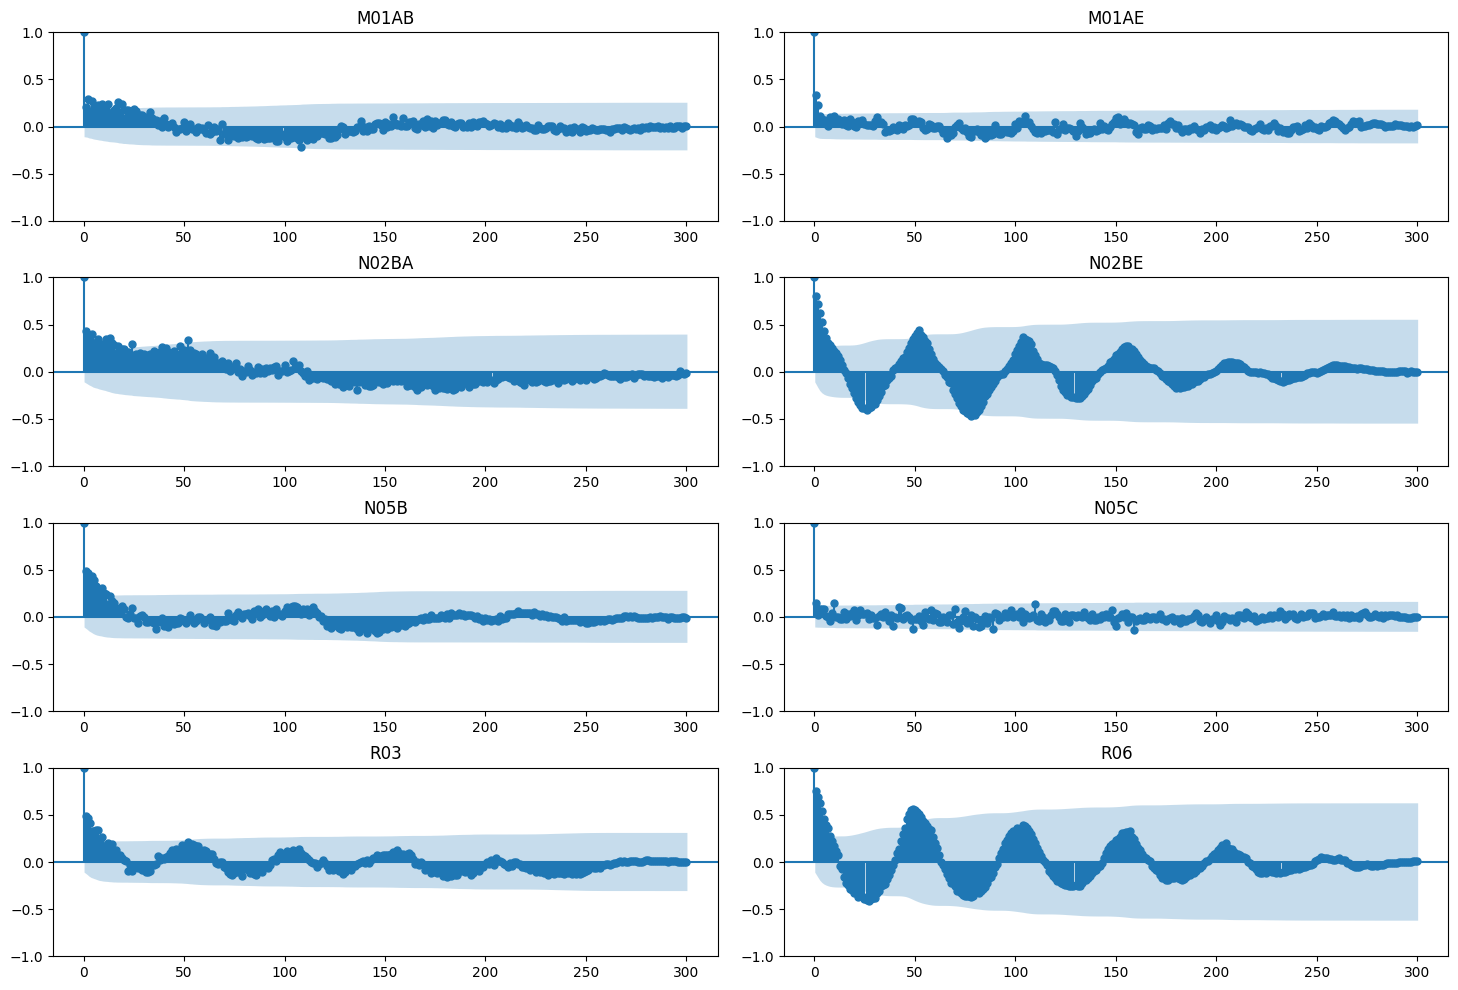

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,12))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_acf(df[x], lags=300, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

### from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=100, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

In [16]:
# Minor autocorrelation is observed at ACF (Auto-Correlation Function) and PACF (Partial Auto-Correlation Function) plots for all series, with exception of N05C sales. N02BE, R03 and R06 series were found to exhibit annual seasonality.

# Data distribution analysis

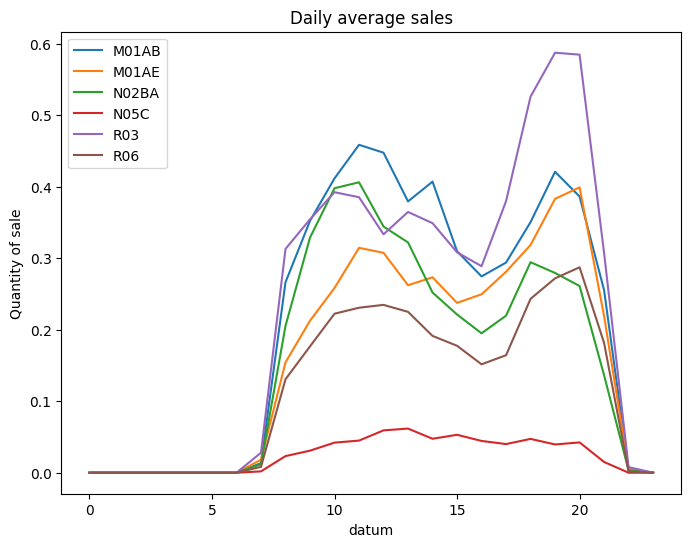

In [17]:
dfatch = pd.read_csv("C:/Users/SUJASH/OneDrive/Desktop/Time Series/data/saleshourly.csv")
dfatch['datum']= pd.to_datetime(dfatch['datum']) 

grp1=dfatch.groupby(dfatch.datum.dt.hour)['M01AB'].mean()
grp2=dfatch.groupby(dfatch.datum.dt.hour)['M01AE'].mean()
grp3=dfatch.groupby(dfatch.datum.dt.hour)['N02BA'].mean()
grp6=dfatch.groupby(dfatch.datum.dt.hour)['N05C'].mean()
grp7=dfatch.groupby(dfatch.datum.dt.hour)['R03'].mean()
grp8=dfatch.groupby(dfatch.datum.dt.hour)['R06'].mean()

plt.title('Daily average sales')
plt.xlabel('Time of day')
plt.ylabel('Quantity of sale')

grp1.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06'], loc='upper left')

plt.show()

# Time series forecasting

In [18]:
resultsRolling={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsRollingdf = pd.DataFrame(resultsRolling)
resultsRollingdf.index = ['Naive MSE', 'Naive MAPE', 'Seasonal Naive MSE', 'Seasonal Naive MAPE', 
                          'ARIMA MSE', 'ARIMA MAPE', 'AutoARIMA MSE', 'AutoARIMA MAPE',
                         'Prophet MSE', 'Prophet MAPE']
resultsLongterm={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsLongtermdf = pd.DataFrame(resultsLongterm)
resultsLongtermdf.index = ['Average MSE', 'Average MAPE', 'ARIMA MSE', 'ARIMA MAPE', 
                           'AutoARIMA MSE', 'AutoARIMA MAPE', 'Prophet MSE', 'Prophet MAPE',
                          'Vanilla LSTM MSE', 'Vanilla LSTM MAPE', 'Stacked LSTM MSE', 'Stacked LSTM MAPE',
                          'Bidirectional LSTM MSE', 'Bidirectional LSTM MAPE']

# Naïve forecasting

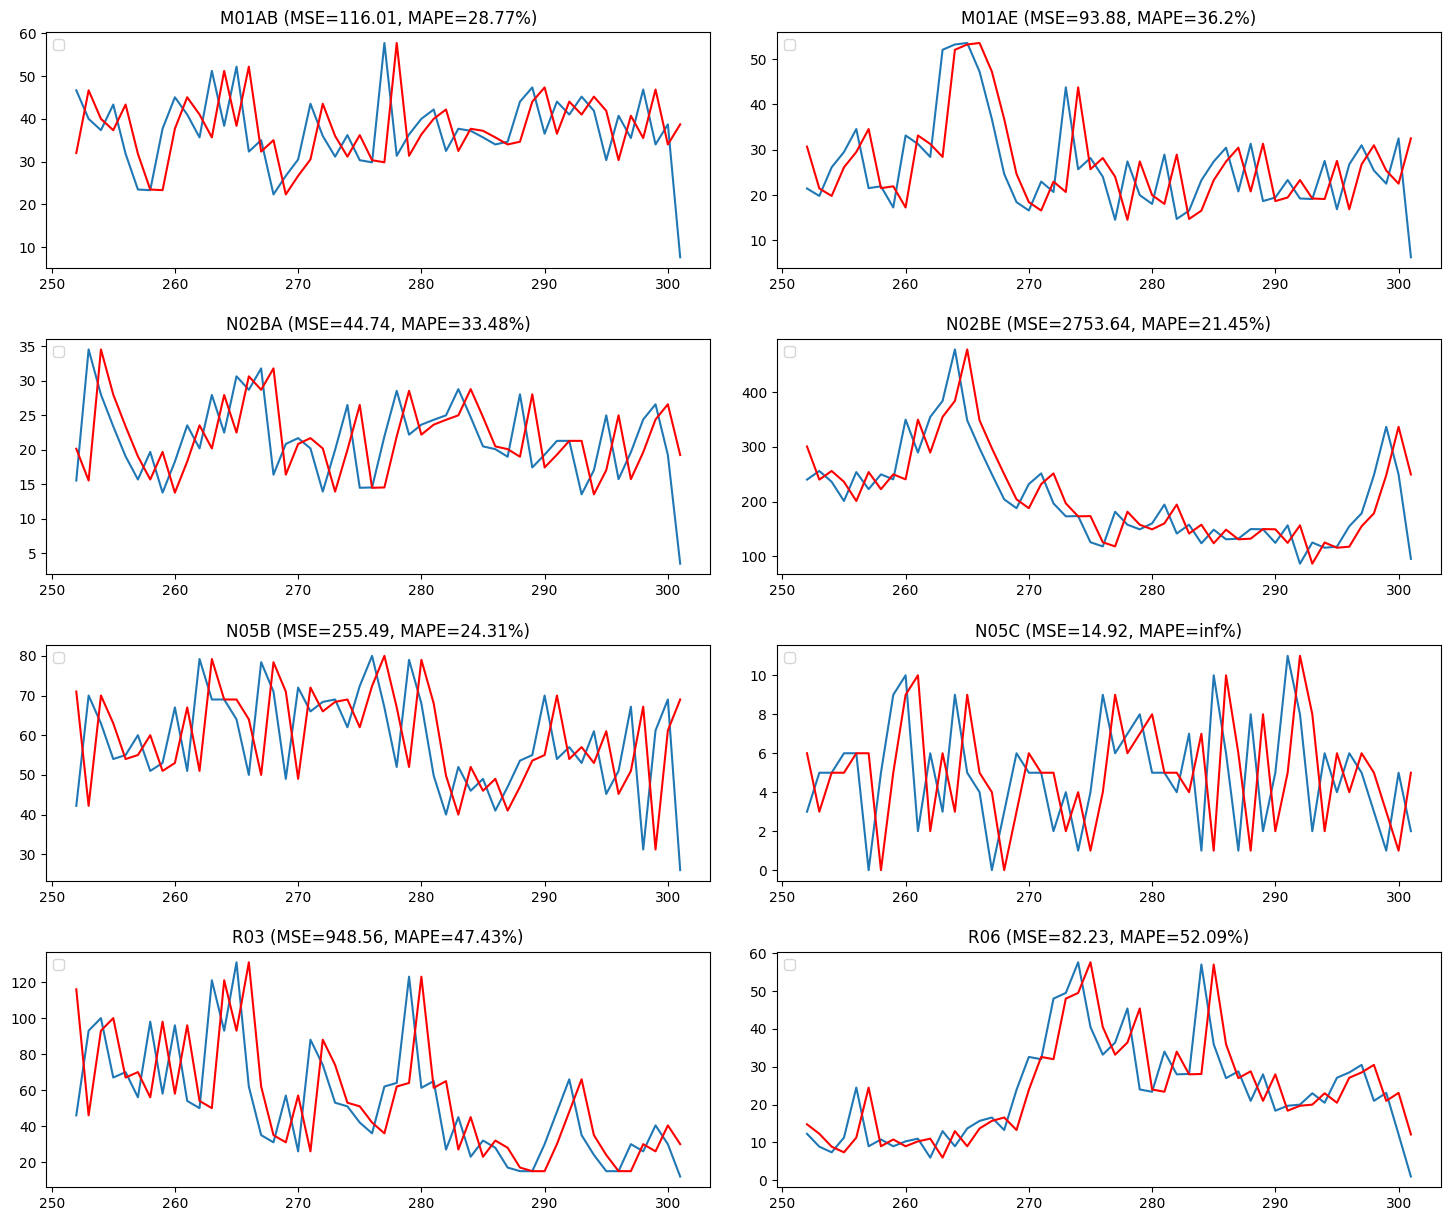

In [19]:
df = pd.read_csv("C:/Users/SUJASH/OneDrive/Desktop/Time Series/data/salesweekly.csv")
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ds=df[x]
    dataframe = concat([ds.shift(1), ds], axis=1)
    dataframe.columns = ['t+1', 't-1']
    size = len(dataframe)-50
    X=dataframe['t-1']
    Y=dataframe['t+1']
    test, predictions = X[size:len(X)], Y[size:len(Y)]
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Naive MSE',x]=error
    resultsRollingdf.loc['Naive MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

# Average method forecasting

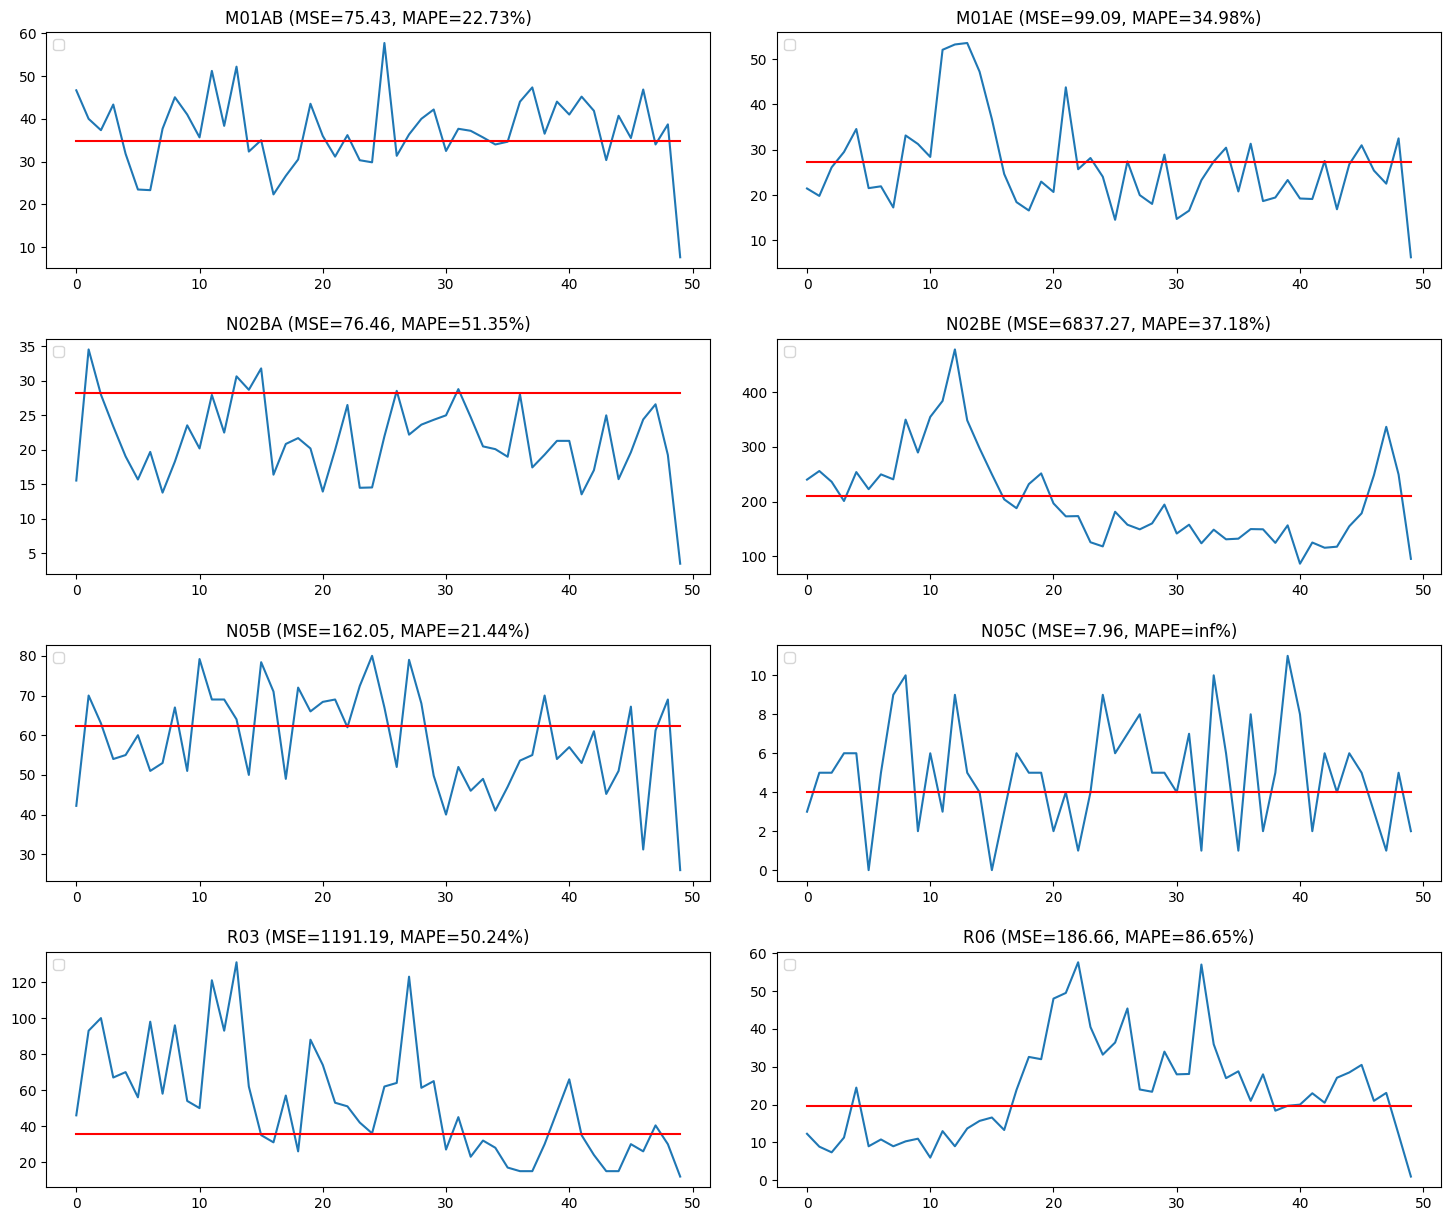

In [20]:
df = pd.read_csv("C:/Users/SUJASH/OneDrive/Desktop/Time Series/data/salesweekly.csv")
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-50
    test = X[size:len(X)] 
    mean = np.mean(X[0:size])
    predictions = np.full(50,mean)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['Average MSE',x]=error
    resultsLongtermdf.loc['Average MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

# Seasonal Naïve forecasting

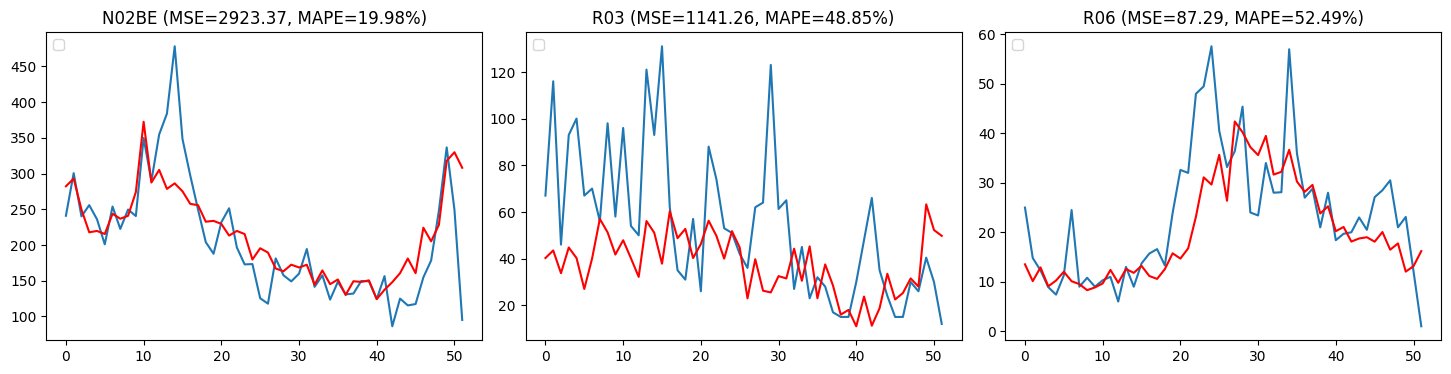

In [21]:
df = pd.read_csv("C:/Users/SUJASH/OneDrive/Desktop/Time Series/data/salesweekly.csv")
subplotindex=0
numrows=1
numcols=3
fig, ax = plt.subplots(numrows, numcols, figsize=(18,4))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['N02BE','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-52
    test = X[size:len(X)]
    train = X[0:size]
    predictions=list()
    history = [x for x in train]
    for i in range(len(test)):
        obs=list()
        for y in range(1,5):
            obs.append(train[-(y*52)+i])
        yhat = np.mean(obs)
        predictions.append(yhat)
        history.append(test[i])
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Seasonal Naive MSE',x]=error
    resultsRollingdf.loc['Seasonal Naive MAPE',x]=perror
    ax[colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[colindex].plot(test)
    ax[colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()    

# ARIMA Forecasting

In [22]:
# Choosing parameters for ARIMA model

In [23]:
import statsmodels.api as sm
df = pd.read_csv("C:/Users/SUJASH/OneDrive/Desktop/Time Series/data/salesweekly.csv")
warnings.filterwarnings("ignore")
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    resDiff = sm.tsa.arma_order_select_ic(df[x], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q,'+x+') =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q,M01AB) = (3, 3) is the best.
ARMA(p,q,M01AE) = (2, 0) is the best.
ARMA(p,q,N02BA) = (3, 3) is the best.
ARMA(p,q,N02BE) = (2, 2) is the best.
ARMA(p,q,N05B) = (4, 3) is the best.
ARMA(p,q,N05C) = (3, 3) is the best.
ARMA(p,q,R03) = (1, 1) is the best.
ARMA(p,q,R06) = (2, 2) is the best.


In [29]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

df1 = pd.read_csv("C:/Users/SUJASH/OneDrive/Desktop/Time Series/data/salesweekly.csv")

for f in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    evaluate_models(f, df1[f].values, p_values, d_values, q_values)
0    

M01AB - Best ARIMANone MSE=inf
M01AE - Best ARIMANone MSE=inf
N02BA - Best ARIMANone MSE=inf
N02BE - Best ARIMANone MSE=inf
N05B - Best ARIMANone MSE=inf
N05C - Best ARIMANone MSE=inf
R03 - Best ARIMANone MSE=inf
R06 - Best ARIMANone MSE=inf


0

In [28]:
df

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.670,21.30,185.950,41.0,0.0,32.000000,7.00
1,1/12/2014,29.33,12.680,37.90,190.700,88.0,5.0,21.000000,7.20
2,1/19/2014,30.67,26.340,45.90,218.400,80.0,8.0,29.000000,12.00
3,1/26/2014,34.00,32.370,31.50,179.600,80.0,8.0,23.000000,10.00
4,2/2/2014,31.02,23.350,20.70,159.880,84.0,12.0,29.000000,12.00
...,...,...,...,...,...,...,...,...,...
297,9/15/2019,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50
298,9/22/2019,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00
299,9/29/2019,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10
300,10/6/2019,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13


In [16]:
import fbprophet
df = pd.read_csv("C:/Users/SUJASH/OneDrive/Desktop/Time Series/data/salesweekly.csv")


ModuleNotFoundError: No module named 'fbprophet'

In [15]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached Cython-3.0.11-cp312-cp312-win_amd64.whl.metadata (3.2 kB)
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12.tar.gz (5.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting r

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [20 lines of output]
  Traceback (most recent call last):
    File "C:\Users\SUJASH\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\SUJASH\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\SUJASH\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
      return hook(config_settings)
             ^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\SUJASH\AppData\Local\Temp\pip-build-env-zd3_lywk\overlay\Lib\site-packages\setuptools\buil

In [7]:
!pip install prophet


  Using cached holidays-0.54-py3-none-any.whl.metadata (23 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB 653.6 kB/s eta 0:00:21
   ---------------------------------------- 0.2/13.3 MB 1.6 MB/s eta 0:00:09
    --------------------------------------- 0.3/13.3 MB 2.5 MB/s eta 0:00:06
   -- ------------------------------------- 0.8/13.3 MB 4.4 MB/s eta 0:00:03
   ---- ----------------------------------- 1.6/13.3 MB 7.3 MB/s eta 0:00:02
   -------- ------------------------------- 2.8/13.3 MB 10.5 MB/s eta 0:00:02
   ----------- ---------------------------- 3.9/13.3 MB 11.8 MB/s eta 0:00:01
   --------------- ------------------------ 5.2/13.3 MB 14.3 MB/s eta 0:00:01
   ------------------- -------------------- 6.4/13.3 MB 15.7 MB/s eta 0:00:01
   ---------------------- ----------------- 7.6/13.3 MB 16.7 MB/s eta 0:00:01
   ------------------------- -------------- 8.3/13.3 MB 17.2 MB/s eta 0:00:01
   ---------


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
!pip install pystan==2.19.1.1
!pip install fbprophet

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [20 lines of output]
  Traceback (most recent call last):
    File "C:\Users\SUJASH\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\SUJASH\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\SUJASH\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
      return hook(config_settings)
             ^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\SUJASH\AppData\Local\Temp\pip-build-env-jo84jel_\overlay\Lib\site-packages\setuptools\buil

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached Cython-3.0.11-cp312-cp312-win_amd64.whl.metadata (3.2 kB)
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12.tar.gz (5.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting r

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [20 lines of output]
  Traceback (most recent call last):
    File "C:\Users\SUJASH\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\SUJASH\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\SUJASH\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
      return hook(config_settings)
             ^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\SUJASH\AppData\Local\Temp\pip-build-env-ay0ebm3r\overlay\Lib\site-packages\setuptools\buil

In [10]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


In [11]:
M01AB= {
    'series':'M01AB',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[10,30,50],
               'interval_width':[0.0005]
              }
}
M01AE= {
    'series':'M01AE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],
               'interval_width':[0.0005]
              }
}
N02BA= {
    'series':'N02BA',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.005,0.01,0.05,0.1],
                   'interval_width':[0.0005]
              }
}
N02BE= {
    'series':'N02BE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[5,10,50],'seasonality_prior_scale':[150,170,200],
               'interval_width':[0.0005]
              }
}
N05B= {
    'series':'N05B',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[1,5,10],
               'interval_width':[0.0005]
              }
}


N05C= {
    'series':'N05C',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.05,0.08,0.1,0.5],
               'interval_width':[0.0005]
              }
}
R03= {
    'series':'R03',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[120,160,200],
               'interval_width':[0.0005]
              }
}
R06= {
    'series':'R06',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[100,120,160,200],
               'interval_width':[0.0005]
              }
}

In [ ]:

r=[M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]
warnings.filterwarnings("ignore")

for x in r:
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = int(len(dfg) - 50)
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    predictions = list()
    minError=0
    grid = ParameterGrid(x['params_grid'])
    for p in grid:
        model = fbprophet.Prophet(**p, daily_seasonality=False, weekly_seasonality=False)
        if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
            model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                fourier_order=13)
        model_fit = model.fit(dfgtrain)
        future = model.make_future_dataframe(periods=50, freq='W')
        output = model.predict(future)
        predictions=output.loc[size+2:len(dfg),:]['yhat'].values
        error = mean_squared_error(dfgtest['y'].values, predictions)
        if(minError>0):
            if(error<minError):
                minError=error
                minP=p
        else:
            minError=error
            minP=p


    print(minP)
    print('Test MSE ('+x['series']+'): %.3f' % minError)   